In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [3]:
TARGET_COLUMN = 'vocal_channel'
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

# Dataset preparation

In [4]:
try:
    excluded_prefixes = ['zc']
    columns_to_remove = []
    for column in df[numerical_attr_list].columns:
        if column.startswith(tuple(excluded_prefixes)) or column == TARGET_COLUMN:
            columns_to_remove.append(column)

    columns_to_remove;
    df = df.drop(columns=columns_to_remove, axis=1)
    
except KeyError as e:
    print(e)
    
for col in columns_to_remove:
    try:
        print(col)
        numerical_attr_list.remove(col)
    except ValueError as e:
        print(e, f"raised by column '{col}'")
        

zc_sum
zc_mean
zc_std
zc_kur
zc_skew
zc_mean_w1
zc_sum_w2
zc_skew_w2
zc_sum_w3
zc_kur_w3
zc_sum_w4
zc_mean_w4


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
scaler = MinMaxScaler()
X = scaler.fit_transform(df[numerical_attr_list])

label_enc = LabelEncoder()
y = label_enc.fit_transform(df[TARGET_COLUMN])

# print(f"numerical_attr_list is {numerical_attr_list}")
print(f"target variable: {np.unique(y, return_counts=True)}")
print(f"X has shape {X.shape}")

target variable: (array([0, 1]), array([1003, 1426]))
X has shape (2429, 231)


In [6]:
from sklearn.model_selection import train_test_split

# Divide in train, test, validation
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
test_mask = df.actor_number >= 19
df.drop(columns="actor_number", inplace=True)

X_test, y_test = X[test_mask], y[test_mask]

X_train, X_val, y_train, y_val = train_test_split(X[~test_mask], y[~test_mask], test_size=0.2)
print(f"Train: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}")

Train: (1449, 231)
Val: (363, 231)
Test: (617, 231)


### Default plots

In [118]:
# Shows the decision boundaries in the embedding
def boundaries_on_embedding(reducer, predictor, 
                            embedding=None, n_pts=30,
                            ax=None,
                            **kwargs):
    
    global X, y, X_train, X_test,X_val, y_train, y_test, y_val
    cmap, title = kwargs.get("cmap", "viridis"), kwargs.get("title", "Decision boundaries on embedding")
    
    edges_color = (0.2, 0.2, 0.2)
    edges_color_neg = (0.8, 0.8, 0.8)
    
    if embedding is None:
        embedding =  reducer.fit_transform(X)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
        
    # Generate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), n_pts)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), n_pts)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    results = predictor.predict(points_in_gigaspace).reshape(old_shape)
    plt.contourf(XX, YY, results.T, cmap=cmap, alpha=0.6, levels=len(np.unique(y))-1)
    plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], 
                marker="o", 
                edgecolor=None,  
                s=7, 
                cmap=cmap,
                alpha=1,
                label="train+val")
    plt.scatter(*embedding[test_mask].T, c=y_test, 
                marker="o", 
                edgecolor=edges_color, 
                s=7,
                cmap=cmap,
                alpha=1,
                label="test")
    plt.contour(XX, YY, results.T, alpha=1, levels=len(np.unique(y))-1, colors=[edges_color, edges_color_neg])

    plt.legend()
    plt.axis("off");
    plt.title(title);
    plt.savefig(f"images/{title.replace(' ', '_')}.png")

In [8]:
from sklearn.metrics import confusion_matrix

def plot_cfm(y_true, y_pred, title="Confusion matrix", cmap="Greens"):
    fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
    cf = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf, annot=True, cmap=cmap, fmt=".4g", cbar=False, ax=ax)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    ticks = np.unique(y_true)
    ax.set_xticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_yticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    
    plt.savefig(f"images/{title.replace(' ', '_')}.pdf")

### Select and embedding

In [9]:
from sklearn.decomposition import PCA

reducer = PCA(n_components=2)
embedding = reducer.fit_transform(X)

In [10]:
# Some properties
N_PTS = 80
CMAP = "Spectral"
CMAP_CFM = "RdGy_r"

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-07-08 16:32:46,203] A new study created in memory with name: no-name-62f13531-2713-44ca-9185-a9de1cd3b492
[W 2023-07-08 16:32:46,216] Trial 1 failed with parameters: {'penalty': 'none', 'C': 4.835002112067491, 'solver': 'liblinear'} because of the following error: ValueError("penalty='none' is not supported for the liblinear solver").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 71, i

[W 2023-07-08 16:32:48,652] Trial 14 failed with parameters: {'penalty': 'elasticnet', 'C': 5.051014173321494, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l

[W 2023-07-08 16:32:49,457] Trial 23 failed with value None.
[W 2023-07-08 16:32:49,484] Trial 24 failed with parameters: {'penalty': 'elasticnet', 'C': 3.8679754690954207, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-08 16:32:49,858] Trial 31 failed with value None.
[W 2023-07-08 16:32:49,880] Trial 32 failed with parameters: {'penalty': 'elasticnet', 'C': 3.7450201216694476, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-08 16:32:50,128] Trial 39 failed with value None.
[W 2023-07-08 16:32:50,126] Trial 40 failed with parameters: {'penalty': 'elasticnet', 'C': 3.3214524019474743, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-08 16:32:50,384] Trial 48 failed with parameters: {'penalty': 'elasticnet', 'C': 3.6946188200508385, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' pena

[W 2023-07-08 16:32:50,629] Trial 52 failed with value None.
[W 2023-07-08 16:32:50,662] Trial 56 failed with parameters: {'penalty': 'elasticnet', 'C': 3.705947210461182, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-08 16:32:50,795] Trial 61 failed with value None.
[W 2023-07-08 16:32:50,814] Trial 62 failed with value None.
[W 2023-07-08 16:32:50,815] Trial 64 failed with parameters: {'penalty': 'elasticnet', 'C': 3.808650037039195, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_mode

[W 2023-07-08 16:32:50,976] Trial 69 failed with value None.
[W 2023-07-08 16:32:50,979] Trial 71 failed with value None.
[W 2023-07-08 16:32:50,985] Trial 70 failed with value None.
[W 2023-07-08 16:32:50,997] Trial 72 failed with parameters: {'penalty': 'elasticnet', 'C': 3.78700996727234, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/D

[W 2023-07-08 16:32:51,162] Trial 76 failed with value None.
[W 2023-07-08 16:32:51,163] Trial 78 failed with value None.
[W 2023-07-08 16:32:51,165] Trial 77 failed with value None.
[W 2023-07-08 16:32:51,167] Trial 79 failed with value None.
[W 2023-07-08 16:32:51,187] Trial 80 failed with parameters: {'penalty': 'elasticnet', 'C': 3.8538550593594247, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penal

[W 2023-07-08 16:32:51,353] Trial 86 failed with value None.
[W 2023-07-08 16:32:51,364] Trial 88 failed with parameters: {'penalty': 'elasticnet', 'C': 3.5405344809386974, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-08 16:32:51,553] Trial 96 failed with parameters: {'penalty': 'elasticnet', 'C': 3.9125595510925666, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' pena

[W 2023-07-08 16:32:51,736] Trial 104 failed with parameters: {'penalty': 'elasticnet', 'C': 3.8007660430865995, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' pen

[W 2023-07-08 16:32:51,891] Trial 108 failed with value None.
[W 2023-07-08 16:32:51,937] Trial 112 failed with parameters: {'penalty': 'elasticnet', 'C': 3.98875085038195, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-08 16:32:52,150] Trial 121 failed with parameters: {'penalty': 'elasticnet', 'C': 3.752982225794204, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' pena

[W 2023-07-08 16:32:52,406] Trial 129 failed with value None.
[W 2023-07-08 16:32:52,428] Trial 130 failed with parameters: {'penalty': 'elasticnet', 'C': 3.828190013185204, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueE

[W 2023-07-08 16:32:52,662] Trial 138 failed with value None.
[W 2023-07-08 16:32:52,669] Trial 137 failed with parameters: {'penalty': 'elasticnet', 'C': 3.6431435450240315, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise Value

[W 2023-07-08 16:32:53,023] Trial 145 failed with value None.
[W 2023-07-08 16:32:53,023] Trial 146 failed with parameters: {'penalty': 'elasticnet', 'C': 3.8210673066389926, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise Value

In [13]:
best_params = study.best_params
logr = LogisticRegression(**best_params)

# Trains on test AND validation
logr.fit(np.concatenate((X_train, X_val)), np.concatenate([y_train, y_val]))

y_pred_test = logr.predict(X_test)

from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 1.665110527631103, 'solver': 'sag'}
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       262
           1       1.00      0.93      0.96       355

    accuracy                           0.96       617
   macro avg       0.95      0.96      0.96       617
weighted avg       0.96      0.96      0.96       617

Accuracy 0.9578606158833063
F1-score [0.95255474 0.96209913]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

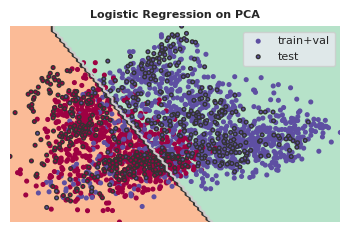

In [119]:
boundaries_on_embedding(reducer, logr, embedding=embedding, 
                        title="Logistic Regression on PCA", 
                        cmap="Spectral",
                        n_pts=N_PTS)

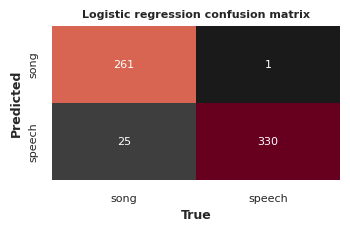

In [15]:
plot_cfm(y_test, y_pred_test, title="Logistic regression confusion matrix", cmap=CMAP_CFM)

# Support Vector Machine

## Linear SVM

In [16]:
from sklearn.svm import LinearSVC

In [17]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    
    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_train, y_train)
    
    y_pred = lin_svc.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 16:32:57,191] A new study created in memory with name: no-name-f4e3085f-200b-43ae-80f9-f5d21da94588
[W 2023-07-08 16:32:57,209] Trial 1 failed with parameters: {'penalty': 'l1', 'C': 34.131330480513846, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/py

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-07-08 16:32:57,709] Trial 8 failed with value None.
[I 2023-07-08 16:32:57,733] Trial 4 finished with value: 0.9724517906336089 and parameters: {'penalty': 'l2', 'C': 94.72941702080843, 'loss': 'hinge'}. Best is trial 5 with value: 0.9724517906336089.
[W 2023-07-08 16:32:57,738] Trial 11 failed with parameters: {'penalty': 'l1', 'C': 35.480601464779284, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  Fil

[W 2023-07-08 16:32:58,726] Trial 20 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-08 16:32:58,796] Trial 17 finished with value: 0.9669421487603306 and parameters: {'penalty': 'l2', 'C': 47.91807833101347, 'loss': 'hinge'}. Best is trial 13 with value: 0.9752066115702479.
[W 2023-07-08 16:32:58,840] Trial 22 failed with parameters: {'penalty': 'l1', 'C': 2.136654451853225, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_tri

[W 2023-07-08 16:32:59,118] Trial 27 failed with value None.
[W 2023-07-08 16:32:59,159] Trial 26 failed with parameters: {'penalty': 'l1', 'C': 98.96142099160015, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 16:32:59,348] Trial 32 failed with value None.
[W 2023-07-08 16:32:59,346] Trial 31 failed with value None.
[W 2023-07-08 16:32:59,435] Trial 36 failed with parameters: {'penalty': 'l1', 'C': 1.5272391369385545, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/dja

[W 2023-07-08 16:32:59,565] Trial 39 failed with parameters: {'penalty': 'l1', 'C': 1.0967598027541072, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-07-08 16:32:59,674] Trial 43 failed with value None.
[W 2023-07-08 16:32:59,674] Trial 45 failed with parameters: {'penalty': 'l1', 'C': 2.8730799939155247, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-08 16:32:59,799] Trial 48 failed with value None.
[W 2023-07-08 16:32:59,852] Trial 50 failed with value None.
[W 2023-07-08 16:32:59,863] Trial 52 failed with parameters: {'penalty': 'l1', 'C': 11.50533616218642, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djan

[W 2023-07-08 16:32:59,980] Trial 55 failed with value None.
[W 2023-07-08 16:32:59,986] Trial 57 failed with parameters: {'penalty': 'l1', 'C': 6.231820012613504, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 16:33:00,154] Trial 63 failed with parameters: {'penalty': 'l1', 'C': 6.0291535915878, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
 

[W 2023-07-08 16:33:00,305] Trial 67 failed with value None.
[W 2023-07-08 16:33:00,311] Trial 69 failed with parameters: {'penalty': 'l1', 'C': 3.797293515750738, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 16:33:00,492] Trial 74 failed with value None.
[W 2023-07-08 16:33:00,486] Trial 75 failed with value None.
[W 2023-07-08 16:33:00,489] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 98.34906600796755, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djan

[W 2023-07-08 16:33:00,600] Trial 79 failed with value None.
[W 2023-07-08 16:33:00,620] Trial 80 failed with value None.
[W 2023-07-08 16:33:00,627] Trial 78 failed with value None.
[W 2023-07-08 16:33:00,628] Trial 81 failed with parameters: {'penalty': 'l1', 'C': 10.359783597736069, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_,

[W 2023-07-08 16:33:00,799] Trial 87 failed with parameters: {'penalty': 'l1', 'C': 7.678628631201022, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear

[W 2023-07-08 16:33:00,918] Trial 91 failed with value None.
[W 2023-07-08 16:33:00,910] Trial 92 failed with value None.
[W 2023-07-08 16:33:00,980] Trial 94 failed with parameters: {'penalty': 'l1', 'C': 7.241149269239244, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djan

[W 2023-07-08 16:33:01,118] Trial 100 failed with parameters: {'penalty': 'l1', 'C': 1.1450071476462753, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_libline

[W 2023-07-08 16:33:01,263] Trial 103 failed with value None.
[W 2023-07-08 16:33:01,264] Trial 104 failed with parameters: {'penalty': 'l1', 'C': 4.502959937277957, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/si

[W 2023-07-08 16:33:01,382] Trial 108 failed with parameters: {'penalty': 'l1', 'C': 2.316572379200707, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-07-08 16:33:01,598] Trial 118 failed with parameters: {'penalty': 'l1', 'C': 7.861323029533466, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-07-08 16:33:01,738] Trial 123 failed with value None.
[W 2023-07-08 16:33:01,733] Trial 122 failed with value None.
[W 2023-07-08 16:33:01,738] Trial 124 failed with parameters: {'penalty': 'l1', 'C': 5.413585673899419, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/d

[W 2023-07-08 16:33:01,844] Trial 128 failed with value None.
[W 2023-07-08 16:33:01,878] Trial 127 failed with value None.
[W 2023-07-08 16:33:01,885] Trial 129 failed with parameters: {'penalty': 'l1', 'C': 2.847382336982861, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/d

[W 2023-07-08 16:33:02,071] Trial 136 failed with value None.
[W 2023-07-08 16:33:02,074] Trial 134 failed with parameters: {'penalty': 'l1', 'C': 0.9862492791996047, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/s

[W 2023-07-08 16:33:02,210] Trial 141 failed with value None.
[W 2023-07-08 16:33:02,212] Trial 140 failed with parameters: {'penalty': 'l1', 'C': 7.486154825941043, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/si

[W 2023-07-08 16:33:02,364] Trial 146 failed with value None.
[W 2023-07-08 16:33:02,366] Trial 147 failed with parameters: {'penalty': 'l1', 'C': 10.07547904439879, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/si

In [18]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 36.91343629815296, 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       262
           1       0.99      0.93      0.96       355

    accuracy                           0.95       617
   macro avg       0.95      0.96      0.95       617
weighted avg       0.96      0.95      0.95       617

Accuracy 0.9529983792544571
F1-score [0.94698355 0.95778748]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


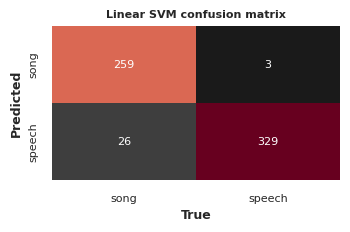

In [19]:
plot_cfm(y_test, y_pred_test, title="Linear SVM confusion matrix", cmap=CMAP_CFM)

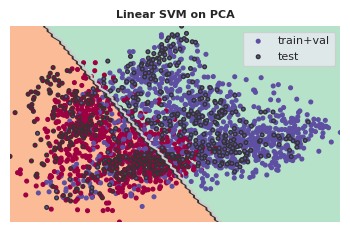

In [120]:
boundaries_on_embedding(reducer, lin_svc, embedding=embedding, 
                        title="Linear SVM on PCA", 
                        cmap=CMAP,
                       n_pts=N_PTS)

In [21]:
# decision_function = lin_svc.decision_function(X_train)
# support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
# support_vectors = X_train[support_vector_indices]

In [22]:
# # Plots the decision function for diferent values of C
# for i, C in enumerate([0.02, 300]):
#     plt.figure(figsize=default_style.SHORT_HALFSIZE_FIGURE)

#     cmap="viridis"
#     clf = LinearSVC(C=C, loss="hinge", penalty='l2', random_state=42).fit(X_test, y_test)

#     # Genearate a grid in embedding
#     xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), 30)
#     yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), 30)

#     XX, YY = np.meshgrid(xx, yy)
#     points_in_embedding = np.array(np.meshgrid(xx, yy)).T
#     old_shape = points_in_embedding.shape[:-1]
    
#     # Maps them back in the big space
#     points_in_embedding = points_in_embedding.reshape(-1,2)
#     points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

#     # Gets results
#     results = clf.decision_function(points_in_gigaspace)
#     mappable=plt.contourf(XX, YY, results.reshape(old_shape).T, cmap="viridis", alpha=0.6, levels=15)
#     plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
#     plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    
#     # Plot support
#     results = clf.decision_function(X_train)
#     support_vector_indices = np.where((2 * y_train - 1) * results <= 1)[0]
#     plt.scatter(*(embedding[~test_mask][support_vector_indices]).T, s=10, color="r")
#     plt.axis("off")
# #     decision_function = clf.decision_function(X_res_t)
# # #     we can also calculate the decision function manually
# # #     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
# #     support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# #     support_vectors = X_res_t[support_vector_indices]
# #     support_vectors_pca = pca.transform(support_vectors)

# #     plt.subplot(1, 2, i + 1)
# #     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
# #     ax = plt.gca()
# #     xlim = ax.get_xlim()
# #     ylim = ax.get_ylim()
# #     xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
# #                          np.linspace(ylim[0], ylim[1], 50))
# #     clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
# #     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# #     Z = Z.reshape(xx.shape)
# #     plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
# #                 linestyles=['--', '-', '--'])
# #     plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
# #                 linewidth=1, facecolors='none', edgecolors='k')
# #     plt.title("C=" + str(C))
# #     #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
# # plt.tight_layout()
# # plt.show()
#     plt.savefig(f"images/linear_svm_UMAP_decision_function_C_{C}.pdf")
#     plt.colorbar(mappable)

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [23]:
from sklearn.svm import SVC

In [24]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.1,80)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_train, y_train)
    y_pred = lin_svc.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 250, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 16:33:05,060] A new study created in memory with name: no-name-6b07ff4f-ac8f-4a8e-a557-cf5161bd6edd
[I 2023-07-08 16:33:05,197] Trial 0 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 19.1972818341155, 'gamma': 0.735701489010131}. Best is trial 0 with value: 0.9834710743801653.
[I 2023-07-08 16:33:05,344] Trial 4 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 38.29404442739193, 'gamma': 0.1850400957844151}. Best is trial 0 with value: 0.9834710743801653.
[I 2023-07-08 16:33:05,703] Trial 2 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 20.247918804903804, 'gamma': 0.46860155176534585}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:05,791] Trial 3 finished with value: 0.6115702479338843 and parameters: {'kernel': 'sigmoid', 'C': 5.099649918696887, 'gamma': 0.8081888986100003}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:05,947] Tria

[I 2023-07-08 16:33:11,812] Trial 38 finished with value: 0.6115702479338843 and parameters: {'kernel': 'sigmoid', 'C': 15.081149388574177, 'gamma': 0.3658690294369059}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:11,966] Trial 39 finished with value: 0.6115702479338843 and parameters: {'kernel': 'sigmoid', 'C': 7.098029576760876, 'gamma': 0.5812276470709519}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:12,038] Trial 42 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 5.625738674159086, 'gamma': 0.5872713945858385}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:12,090] Trial 40 finished with value: 0.6115702479338843 and parameters: {'kernel': 'sigmoid', 'C': 15.933828025321697, 'gamma': 0.6002967481366509}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:12,170] Trial 43 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 6.48177647697914

[I 2023-07-08 16:33:18,077] Trial 76 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 10.334036920006087, 'gamma': 0.6990751217447259}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:18,331] Trial 77 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 18.726442658352646, 'gamma': 0.6108307524554156}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:18,511] Trial 79 finished with value: 0.6115702479338843 and parameters: {'kernel': 'sigmoid', 'C': 17.94959874556485, 'gamma': 0.6242345332869493}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:18,908] Trial 80 finished with value: 0.6115702479338843 and parameters: {'kernel': 'sigmoid', 'C': 8.071979975295562, 'gamma': 0.6187534073160869}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:18,931] Trial 83 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 7.724761628474171, 'ga

[I 2023-07-08 16:33:25,296] Trial 119 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 17.439907319363037, 'gamma': 0.37915431967752555}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:25,339] Trial 118 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 31.47882333790669, 'gamma': 0.4589610067864876}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:25,365] Trial 117 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 26.32533196408078, 'gamma': 0.4644130953819436}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:25,396] Trial 116 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 26.461699019906835, 'gamma': 0.46104102905778477}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:25,712] Trial 120 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 26.855610319949065, 'ga

[I 2023-07-08 16:33:31,325] Trial 155 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 30.543339797932767, 'gamma': 0.461756989546982}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:31,444] Trial 157 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 29.61387461175855, 'gamma': 0.44229388384813695}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:31,550] Trial 156 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 32.051973632708275, 'gamma': 0.4723584500237047}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:31,637] Trial 158 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 32.3194097222656, 'gamma': 0.4657096400832409}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:31,858] Trial 159 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 32.48460862930907, 'gamma'

[I 2023-07-08 16:33:38,028] Trial 194 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 25.359268878095598, 'gamma': 0.4183864192801283}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:38,303] Trial 195 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 23.577825382322878, 'gamma': 0.41167749671703857}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:38,380] Trial 196 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 25.02825730081843, 'gamma': 0.4065910285178819}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:38,580] Trial 198 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 23.25523083863483, 'gamma': 0.4073476417525262}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:38,591] Trial 197 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 24.94562926532224, 'gamm

[I 2023-07-08 16:33:44,715] Trial 233 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 37.519249769711315, 'gamma': 0.4615800166195516}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:44,875] Trial 232 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 11.462692323929202, 'gamma': 0.5948597777216981}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:44,982] Trial 235 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 37.216076460194, 'gamma': 0.462975369503343}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:45,114] Trial 238 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 26.205335631687024, 'gamma': 0.49871305698729135}. Best is trial 2 with value: 0.9944903581267218.
[I 2023-07-08 16:33:45,331] Trial 237 finished with value: 0.9944903581267218 and parameters: {'kernel': 'rbf', 'C': 29.300026974596523, 'gamm

In [25]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(np.concatenate((X_train, X_val)),np.concatenate((y_train, y_val)))

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'rbf', 'C': 20.247918804903804, 'gamma': 0.46860155176534585}
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       262
           1       0.98      0.95      0.96       355

    accuracy                           0.96       617
   macro avg       0.96      0.96      0.96       617
weighted avg       0.96      0.96      0.96       617

Accuracy 0.9578606158833063
F1-score [0.95149254 0.96275072]


In [26]:
print(svc.support_vectors_.shape)
print(X.shape)

(643, 231)
(2429, 231)


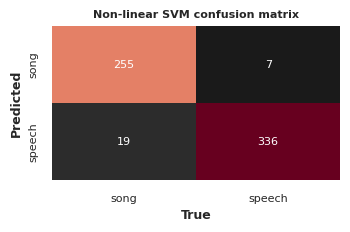

In [27]:
plot_cfm(y_test, y_pred_test, title="Non-linear SVM confusion matrix", cmap=CMAP_CFM)

In [28]:
# support_vectors_pca = pca.transform(svc.support_vectors_)

In [29]:
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
#             cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=10)
# plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=10,
#                 linewidth=1, facecolors='none', edgecolors='k')
# plt.show()

In [30]:
# decision_function = svc.decision_function(X_res_t)
# support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# support_vectors = X_res_t[support_vector_indices]

In [31]:
# support_vectors_pca = pca.transform(support_vectors)

In [32]:
# for kernel in ('linear', 'rbf', 'poly'):
#     clf = SVC(kernel=kernel, gamma=0.1, C=26)
#     clf.fit(X_res_t, y_res_t)

#     plt.figure()
#     plt.clf()
#     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, zorder=10, cmap=plt.cm.Paired,
#                 edgecolor='k', s=20)

#     # Circle out the test data
# #     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
# #                 zorder=10, edgecolor='k')

#     plt.axis('tight')
#     x_min = X_pca[:, 0].min()
#     x_max = X_pca[:, 0].max()
#     y_min = X_pca[:, 1].min()
#     y_max = X_pca[:, 1].max()

#     XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
#     clf.fit(X_pca, y_res_t)
#     Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(XX.shape)
#     plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
#     plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
#                 linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

#     plt.title(kernel)
# plt.show()

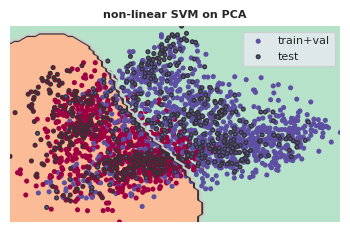

In [121]:
boundaries_on_embedding(reducer, svc, embedding=embedding, 
                        title="non-linear SVM on PCA", 
                        cmap=CMAP,
                        n_pts=N_PTS)
# plt.scatter(*(reducer.transform(svc.support_vectors_).T), color="r", s=10 , marker="+")

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [34]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

2023-07-08 16:33:52.080417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 16:33:52.168341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 16:33:52.169441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 16:33:53.554667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [35]:
from scikeras.wrappers import KerasClassifier

In [36]:
from sklearn.model_selection import RandomizedSearchCV

In [105]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [106]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [107]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    
    net.fit(X_train, y_train, epochs=50)
    y_pred = net.predict(X_val).astype(int)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 17:07:15,907] A new study created in memory with name: no-name-94ee8764-e34c-4933-9268-90bdc8c5e2e8
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
46/46 [==============================] - 5s 11ms/step - loss: 0.6879 - accuracy: 0.6080
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6766 - accuracy: 0.6618
Epoch 3/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6657 - accuracy: 0.5990
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6519 - accuracy: 0.6039
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6313 - accuracy: 0.6246
Epoch 6/50
46/46 [==============================] - 7s 14ms/step - loss: 0.2364 - accuracy: 0.9124
Epoch 2/50
46/46 [==============================] - 8s 16ms/step - loss: 0.7463 - accuracy: 0.4624
Epoch 2/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5944 - accuracy: 0.6915
Epoch 3/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6804 - accuracy: 0.5859
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.504

46/46 [==============================] - 1s 15ms/step - loss: 0.1152 - accuracy: 0.9620
Epoch 21/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1464 - accuracy: 0.9689
Epoch 15/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1124 - accuracy: 0.9607
Epoch 22/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1105 - accuracy: 0.9620
Epoch 23/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0560 - accuracy: 0.9793
Epoch 17/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1310 - accuracy: 0.9724
Epoch 17/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1078 - accuracy: 0.9648
Epoch 24/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1236 - accuracy: 0.9710
Epoch 26/50
Epoch 19/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0780 - accuracy: 0.9738
Epoch 20/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0991 - accuracy: 0.9641


46/46 [==============================] - 1s 14ms/step - loss: 0.0918 - accuracy: 0.9662
Epoch 35/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0616 - accuracy: 0.9807
Epoch 29/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0900 - accuracy: 0.9800
Epoch 29/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0890 - accuracy: 0.9683
Epoch 38/50
Epoch 31/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0820 - accuracy: 0.9827
Epoch 31/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0503 - accuracy: 0.9834
Epoch 32/50
Epoch 32/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0635 - accuracy: 0.9779
Epoch 33/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0352 - accuracy: 0.9896
Epoch 34/50
Epoch 33/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0286 - accuracy: 0.9910
Epoch 34/50
46/46 [==============================] - 1s 16ms/step - loss: 0.

46/46 [==============================] - 1s 13ms/step - loss: 0.0773 - accuracy: 0.9779
Epoch 43/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0599 - accuracy: 0.9793
Epoch 44/50
25/46 [===============>..............] - ETA: 0s - loss: 0.0616 - accuracy: 0.9837

[I 2023-07-08 17:07:54,907] Trial 0 finished with value: 0.9752066115702479 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9752066115702479.


46/46 [==============================] - 1s 15ms/step - loss: 0.0248 - accuracy: 0.9924
Epoch 44/50
 1/46 [..............................] - ETA: 0s - loss: 0.2157 - accuracy: 0.9375

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 17ms/step - loss: 0.0317 - accuracy: 0.9890
Epoch 45/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0765 - accuracy: 0.9772
Epoch 46/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0168 - accuracy: 0.9959
Epoch 46/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0488 - accuracy: 0.9848
Epoch 49/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0411 - accuracy: 0.9841
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0613 - accuracy: 0.9834
Epoch 49/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0204 - accuracy: 0.9924
Epoch 49/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0483 - accuracy: 0.9862
Epoch 50/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0205 - accuracy: 0.9917
Epoch 50/50
38/46 [=======================>......] - ETA: 0s - loss: 0.0479 - accuracy: 0.9819

[I 2023-07-08 17:08:00,257] Trial 2 finished with value: 0.9807162534435262 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 2 with value: 0.9807162534435262.


46/46 [==============================] - 1s 16ms/step - loss: 0.0474 - accuracy: 0.9821


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

12/12 [==============================] - 1s 19ms/step


[I 2023-07-08 17:08:00,869] Trial 3 finished with value: 0.9752066115702479 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 2 with value: 0.9807162534435262.


15/46 [========>.....................] - ETA: 0s - loss: 0.6940 - accuracy: 0.4812

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

33/46 [====================>.........] - ETA: 0s - loss: 0.6916 - accuracy: 0.5303

[I 2023-07-08 17:08:01,283] Trial 1 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 1 with value: 0.9834710743801653.


46/46 [==============================] - 6s 12ms/step - loss: 0.6898 - accuracy: 0.5473
Epoch 2/50
 1/46 [..............................] - ETA: 1s - loss: 0.6837 - accuracy: 0.5938

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.6823 - accuracy: 0.5859
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6795 - accuracy: 0.5859
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6784 - accuracy: 0.5859
Epoch 5/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6779 - accuracy: 0.5859
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6777 - accuracy: 0.5859
Epoch 7/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6775 - accuracy: 0.5859
Epoch 8/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6775 - accuracy: 0.5859
Epoch 9/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6774 - accuracy: 0.5859
Epoch 10/50
46/46 [==============================] - 5s 14ms/step - loss: 0.6008 - accuracy: 0.7088
Epoch 2/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6772 - accuracy: 0.5859
Epoch 13/50
46/46 [=

 1/46 [..............................] - ETA: 0s - loss: 0.1048 - accuracy: 0.9375Epoch 17/50
Epoch 26/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6760 - accuracy: 0.5859
Epoch 27/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0678 - accuracy: 0.9765
Epoch 15/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1022 - accuracy: 0.9703
Epoch 20/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0532 - accuracy: 0.9827
Epoch 17/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0920 - accuracy: 0.9717
Epoch 23/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0605 - accuracy: 0.9821
Epoch 19/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1118 - accuracy: 0.9683
Epoch 20/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1052 - accuracy: 0.9683
Epoch 34/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0909 - accuracy: 0.9703
Epoch 

46/46 [==============================] - 1s 15ms/step - loss: 0.0926 - accuracy: 0.9738
Epoch 27/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0923 - accuracy: 0.9752
Epoch 28/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0423 - accuracy: 0.9848
Epoch 28/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6745 - accuracy: 0.5859
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0842 - accuracy: 0.9745
Epoch 33/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6744 - accuracy: 0.5859
Epoch 43/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0810 - accuracy: 0.9724
Epoch 34/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0866 - accuracy: 0.9765
Epoch 31/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0794 - accuracy: 0.9758
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0405 - accuracy: 0.9876
Epoch 31/50
4

[I 2023-07-08 17:08:32,479] Trial 4 finished with value: 0.6115702479338843 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 1 with value: 0.9834710743801653.


42/46 [==========================>...] - ETA: 0s - loss: 0.0809 - accuracy: 0.9769

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.0327 - accuracy: 0.9896
Epoch 39/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0748 - accuracy: 0.9765
Epoch 44/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0786 - accuracy: 0.9758
Epoch 41/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0747 - accuracy: 0.9800
Epoch 42/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0728 - accuracy: 0.9779
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0716 - accuracy: 0.9793
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0259 - accuracy: 0.9931
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0703 - accuracy: 0.9793
Epoch 45/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0481 - accuracy: 0.9821
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0706 - accuracy: 0.9786
Epoch 49/50
46/46

[I 2023-07-08 17:08:37,703] Trial 7 finished with value: 0.9834710743801653 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 1 with value: 0.9834710743801653.


46/46 [==============================] - 0s 6ms/step - loss: 0.6650 - accuracy: 0.5928
Epoch 5/50
 8/46 [====>.........................] - ETA: 0s - loss: 0.6508 - accuracy: 0.6367

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

12/12 [==============================] - 0s 6ms/steposs: 0.6509 - accuracy: 0.


[I 2023-07-08 17:08:38,081] Trial 5 finished with value: 0.9696969696969697 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 1 with value: 0.9834710743801653.


46/46 [==============================] - 0s 7ms/step - loss: 0.6478 - accuracy: 0.6239
Epoch 6/50
17/46 [==========>...................] - ETA: 0s - loss: 0.6311 - accuracy: 0.6912

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.6232 - accuracy: 0.7274
Epoch 7/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5891 - accuracy: 0.8440
Epoch 8/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5405 - accuracy: 0.8965
Epoch 9/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4667 - accuracy: 0.9303
Epoch 10/50
46/46 [==============================] - 0s 6ms/step - loss: 0.3865 - accuracy: 0.9476
Epoch 11/50
46/46 [==============================] - 0s 11ms/step - loss: 0.3094 - accuracy: 0.9462
Epoch 12/50
46/46 [==============================] - 0s 7ms/step - loss: 0.2423 - accuracy: 0.9572
Epoch 13/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1954 - accuracy: 0.9579
Epoch 14/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1685 - accuracy: 0.9607
Epoch 15/50
46/46 [==============================] - 3s 9ms/step - loss: 0.6571 - accuracy: 0.5866
Epoch 2/50
46/46 [=====

[I 2023-07-08 17:08:48,224] Trial 6 finished with value: 0.9449035812672176 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 1 with value: 0.9834710743801653.


32/46 [===================>..........] - ETA: 0s - loss: 0.0857 - accuracy: 0.9775

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.1055 - accuracy: 0.9634
Epoch 21/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0829 - accuracy: 0.9717
Epoch 36/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1013 - accuracy: 0.9662
Epoch 22/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0866 - accuracy: 0.9703
Epoch 37/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0973 - accuracy: 0.9676
Epoch 24/50
Epoch 23/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0859 - accuracy: 0.9717
Epoch 38/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0945 - accuracy: 0.9655
Epoch 24/50
 9/46 [====>.........................] - ETA: 0s - loss: 0.0874 - accuracy: 0.9757Epoch 26/50
Epoch 25/50
46/46 [==============================] - 1s 10ms/step - loss: 0.0805 - accuracy: 0.9752
Epoch 40/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0930 - accuracy: 0.9

46/46 [==============================] - 0s 8ms/step - loss: 0.0864 - accuracy: 0.9676
Epoch 36/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0943 - accuracy: 0.9676
Epoch 38/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4399 - accuracy: 0.9220
Epoch 12/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0940 - accuracy: 0.9648
Epoch 39/50
46/46 [==============================] - 0s 6ms/step - loss: 0.4173 - accuracy: 0.9248


[I 2023-07-08 17:08:57,719] Trial 8 finished with value: 0.9862258953168044 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 8 with value: 0.9862258953168044.


Epoch 13/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0909 - accuracy: 0.9676
Epoch 40/50
37/46 [=======================>......] - ETA: 0s - loss: 0.0872 - accuracy: 0.9671

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.3946 - accuracy: 0.9282
Epoch 14/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0843 - accuracy: 0.9724
Epoch 40/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3741 - accuracy: 0.9386
Epoch 15/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0917 - accuracy: 0.9676
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3554 - accuracy: 0.9441
Epoch 16/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0903 - accuracy: 0.9662
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3378 - accuracy: 0.9448
Epoch 17/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0898 - accuracy: 0.9683
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0799 - accuracy: 0.9717
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0867 - accuracy: 0.9696
Epoch 18/50
46/46 [===

[I 2023-07-08 17:09:03,671] Trial 9 finished with value: 0.9614325068870524 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 8 with value: 0.9862258953168044.


46/46 [==============================] - 0s 7ms/step - loss: 0.2343 - accuracy: 0.9662
Epoch 26/50
34/46 [=====================>........] - ETA: 0s - loss: 0.0727 - accuracy: 0.9789

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.2276 - accuracy: 0.9655
Epoch 1/50
Epoch 27/50
14/46 [========>.....................] - ETA: 0s - loss: 0.6922 - accuracy: 0.5558

[I 2023-07-08 17:09:04,667] Trial 10 finished with value: 0.977961432506887 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 8 with value: 0.9862258953168044.


46/46 [==============================] - 1s 12ms/step - loss: 0.2200 - accuracy: 0.9676
Epoch 28/50
33/46 [====================>.........] - ETA: 0s - loss: 0.6359 - accuracy: 0.6695

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 7s 12ms/step - loss: 0.5885 - accuracy: 0.7371
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 0.2136 - accuracy: 0.9676
Epoch 1/50
Epoch 29/50
46/46 [==============================] - 1s 13ms/step - loss: 0.2077 - accuracy: 0.9669
Epoch 30/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1540 - accuracy: 0.9572
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.2016 - accuracy: 0.9683
Epoch 31/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1965 - accuracy: 0.9676
Epoch 32/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1051 - accuracy: 0.9627
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1916 - accuracy: 0.9676
Epoch 33/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1049 - accuracy: 0.9634
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1871 - accuracy: 0.9683
Epoch 

46/46 [==============================] - 1s 17ms/step - loss: 0.0585 - accuracy: 0.9807
Epoch 23/50
30/46 [==================>...........] - ETA: 0s - loss: 0.1014 - accuracy: 0.9615Epoch 16/50
Epoch 50/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0541 - accuracy: 0.9807
Epoch 24/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1365 - accuracy: 0.9676
Epoch 17/50
16/46 [=========>....................] - ETA: 0s - loss: 0.0381 - accuracy: 0.9883

[I 2023-07-08 17:09:19,917] Trial 11 finished with value: 0.9669421487603306 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 8 with value: 0.9862258953168044.


42/46 [==========================>...] - ETA: 0s - loss: 0.0781 - accuracy: 0.9695

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 20ms/step - loss: 0.0791 - accuracy: 0.9689
Epoch 11/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0552 - accuracy: 0.9821
Epoch 27/50
46/46 [==============================] - 1s 17ms/step - loss: 0.1029 - accuracy: 0.9669
Epoch 20/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0907 - accuracy: 0.9662
Epoch 13/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0632 - accuracy: 0.9779
Epoch 28/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1029 - accuracy: 0.9669
Epoch 21/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0675 - accuracy: 0.9752
Epoch 14/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0993 - accuracy: 0.9655
Epoch 23/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0694 - accuracy: 0.9745
Epoch 16/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0970 - accuracy: 0.9689
Epoch 24/50


46/46 [==============================] - 1s 13ms/step - loss: 0.0819 - accuracy: 0.9738
Epoch 36/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0418 - accuracy: 0.9848
Epoch 28/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0408 - accuracy: 0.9848
Epoch 44/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0836 - accuracy: 0.9655
Epoch 7/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0340 - accuracy: 0.9890
Epoch 30/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0813 - accuracy: 0.9724
Epoch 39/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0939 - accuracy: 0.9703
Epoch 9/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0486 - accuracy: 0.9855
Epoch 47/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0875 - accuracy: 0.9689
Epoch 10/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0798 - accuracy: 0.9724
Epoch 41/50
Ep

[I 2023-07-08 17:09:38,787] Trial 12 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 8 with value: 0.9862258953168044.


 7/46 [===>..........................] - ETA: 0s - loss: 0.0426 - accuracy: 0.9821

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.0771 - accuracy: 0.9731
Epoch 47/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0670 - accuracy: 0.9758
Epoch 16/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0796 - accuracy: 0.9758
Epoch 39/50
Epoch 17/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0781 - accuracy: 0.9745
Epoch 49/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0535 - accuracy: 0.9800
Epoch 18/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0295 - accuracy: 0.9896
Epoch 40/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0716 - accuracy: 0.9765
Epoch 50/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0570 - accuracy: 0.9814
Epoch 19/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0371 - accuracy: 0.9848
Epoch 41/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0582 - accuracy: 0.9765


[I 2023-07-08 17:09:47,582] Trial 14 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 8 with value: 0.9862258953168044.


46/46 [==============================] - 1s 13ms/step - loss: 0.0972 - accuracy: 0.9669
Epoch 5/50
10/46 [=====>........................] - ETA: 0s - loss: 0.1319 - accuracy: 0.9500Epoch 31/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.1006 - accuracy: 0.9627
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0985 - accuracy: 0.9689
Epoch 7/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0341 - accuracy: 0.9917
Epoch 33/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0933 - accuracy: 0.9683
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0747 - accuracy: 0.9765
Epoch 9/50
44/46 [===========================>..] - ETA: 0s - loss: 0.0709 - accuracy: 0.9766

[I 2023-07-08 17:09:50,562] Trial 13 finished with value: 0.9807162534435262 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 8 with value: 0.9862258953168044.


46/46 [==============================] - 1s 14ms/step - loss: 0.0286 - accuracy: 0.9917
Epoch 36/50
 1/46 [..............................] - ETA: 0s - loss: 0.0296 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.0867 - accuracy: 0.9689
Epoch 11/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0792 - accuracy: 0.9676
Epoch 12/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0293 - accuracy: 0.9917
Epoch 38/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0873 - accuracy: 0.9696
Epoch 13/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0325 - accuracy: 0.9896
Epoch 39/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0282 - accuracy: 0.9896
Epoch 40/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0670 - accuracy: 0.9752
Epoch 15/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0266 - accuracy: 0.9876
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0599 - accuracy: 0.9821
Epoch 16/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0213 - accuracy: 0.9931
Epoch 42/50


[I 2023-07-08 17:10:02,315] Trial 15 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


24/46 [==============>...............] - ETA: 0s - loss: 0.0496 - accuracy: 0.9844

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.0790 - accuracy: 0.9745
Epoch 7/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0759 - accuracy: 0.9731
Epoch 12/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0730 - accuracy: 0.9758
Epoch 8/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0762 - accuracy: 0.9676
Epoch 13/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0414 - accuracy: 0.9855
Epoch 29/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0735 - accuracy: 0.9758
Epoch 9/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0612 - accuracy: 0.9793
Epoch 14/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0633 - accuracy: 0.9793
Epoch 10/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0652 - accuracy: 0.9765
Epoch 11/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0618 - accuracy: 0.9800
Epoch 16/50
46/

46/46 [==============================] - 1s 25ms/step - loss: 0.1405 - accuracy: 0.9558
Epoch 11/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0472 - accuracy: 0.9800
Epoch 30/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0230 - accuracy: 0.9931
Epoch 43/50
46/46 [==============================] - 1s 24ms/step - loss: 0.1328 - accuracy: 0.9558
Epoch 25/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0403 - accuracy: 0.9855
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 0.0414 - accuracy: 0.9834
Epoch 32/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0349 - accuracy: 0.9855
Epoch 45/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1203 - accuracy: 0.9614
Epoch 27/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0390 - accuracy: 0.9876
Epoch 28/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1090 - accuracy: 0.9655
Epoch 34/50


[I 2023-07-08 17:10:24,098] Trial 16 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


20/46 [============>.................] - ETA: 0s - loss: 0.0955 - accuracy: 0.9641Epoch 40/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.0929 - accuracy: 0.9683
Epoch 23/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0476 - accuracy: 0.9841
Epoch 41/50
Epoch 36/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0897 - accuracy: 0.9738
Epoch 24/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0326 - accuracy: 0.9883
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0900 - accuracy: 0.9683
Epoch 25/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0237 - accuracy: 0.9924
Epoch 27/50
Epoch 39/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0251 - accuracy: 0.9917
Epoch 28/50
Epoch 40/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0882 - accuracy: 0.9710
Epoch 29/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0194 - accuracy: 0.9945
Epoch 41/50
46/46 [==============================] - 1s 14ms/step - loss: 0.

[I 2023-07-08 17:10:32,733] Trial 17 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


21/46 [============>.................] - ETA: 0s - loss: 0.0290 - accuracy: 0.9851

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.0790 - accuracy: 0.9710
Epoch 37/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0288 - accuracy: 0.9903
Epoch 38/50
Epoch 49/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0732 - accuracy: 0.9779
Epoch 39/50
Epoch 50/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0745 - accuracy: 0.9752
Epoch 40/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0910 - accuracy: 0.9676
Epoch 6/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0754 - accuracy: 0.9731
Epoch 41/50
28/46 [=================>............] - ETA: 0s - loss: 0.0772 - accuracy: 0.9721

[I 2023-07-08 17:10:36,291] Trial 18 finished with value: 0.9118457300275482 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


32/46 [===================>..........] - ETA: 0s - loss: 0.0793 - accuracy: 0.9707

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 17ms/step - loss: 0.0816 - accuracy: 0.9724
Epoch 7/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0756 - accuracy: 0.9745
Epoch 43/50
Epoch 8/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0795 - accuracy: 0.9710
Epoch 44/50
Epoch 9/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0849 - accuracy: 0.9717
Epoch 10/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0711 - accuracy: 0.9793
Epoch 46/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0963 - accuracy: 0.9669
Epoch 11/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0652 - accuracy: 0.9758
Epoch 12/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0708 - accuracy: 0.9772
Epoch 48/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0676 - accuracy: 0.9758
Epoch 49/50
46/46 [==============================] - 9s 14ms/step - loss: 0.4730 - accuracy

[I 2023-07-08 17:10:44,285] Trial 19 finished with value: 0.9807162534435262 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 15 with value: 0.9889807162534435.


39/46 [========================>.....] - ETA: 0s - loss: 0.1279 - accuracy: 0.9543

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.0563 - accuracy: 0.9827
Epoch 17/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1260 - accuracy: 0.9551
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1127 - accuracy: 0.9627
Epoch 6/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0602 - accuracy: 0.9758
Epoch 18/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0898 - accuracy: 0.9696
Epoch 10/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0560 - accuracy: 0.9814
Epoch 22/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0879 - accuracy: 0.9710
Epoch 12/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1010 - accuracy: 0.9669
Epoch 7/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0609 - accuracy: 0.9793
Epoch 24/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0550 - accuracy: 0.9800
Epoch 25/50
46/

46/46 [==============================] - 1s 13ms/step - loss: 0.0800 - accuracy: 0.9724
Epoch 18/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0669 - accuracy: 0.9745
Epoch 24/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0953 - accuracy: 0.9641
Epoch 8/50
Epoch 35/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0645 - accuracy: 0.9779
Epoch 25/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0226 - accuracy: 0.9924
Epoch 38/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0670 - accuracy: 0.9793
Epoch 28/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0369 - accuracy: 0.9855
Epoch 39/50
36/46 [======================>.......] - ETA: 0s - loss: 0.0371 - accuracy: 0.9896Epoch 29/50
Epoch 13/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0666 - accuracy: 0.9772
Epoch 30/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0531 - accuracy: 0.

46/46 [==============================] - 1s 12ms/step - loss: 0.0140 - accuracy: 0.9952
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0494 - accuracy: 0.9814
Epoch 48/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0605 - accuracy: 0.9814
Epoch 22/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0338 - accuracy: 0.9841
Epoch 49/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0605 - accuracy: 0.9800
Epoch 39/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0503 - accuracy: 0.9862
Epoch 40/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0183 - accuracy: 0.9938
Epoch 25/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0510 - accuracy: 0.9841
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0459 - accuracy: 0.9883
Epoch 36/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0503 - accuracy: 0.9841
Epoch 26/50
Epo

[I 2023-07-08 17:11:12,969] Trial 21 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


46/46 [==============================] - 0s 7ms/step - loss: 0.0533 - accuracy: 0.9821
Epoch 37/50
 9/46 [====>.........................] - ETA: 0s - loss: 0.0643 - accuracy: 0.9653

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.0412 - accuracy: 0.9869
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0603 - accuracy: 0.9758
Epoch 38/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0456 - accuracy: 0.9827
Epoch 39/50
 1/46 [..............................] - ETA: 0s - loss: 0.0387 - accuracy: 1.0000

[I 2023-07-08 17:11:14,107] Trial 20 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


 7/46 [===>..........................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9911

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.0435 - accuracy: 0.9876
Epoch 40/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0470 - accuracy: 0.9855
Epoch 41/50
34/46 [=====================>........] - ETA: 0s - loss: 0.0436 - accuracy: 0.9853

[I 2023-07-08 17:11:15,477] Trial 22 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


46/46 [==============================] - 1s 12ms/step - loss: 0.0453 - accuracy: 0.9848
Epoch 42/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.0422 - accuracy: 0.9841
Epoch 1/50
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0380 - accuracy: 0.9903
Epoch 44/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0397 - accuracy: 0.9869
Epoch 45/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0400 - accuracy: 0.9876
Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0431 - accuracy: 0.9862
Epoch 47/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0500 - accuracy: 0.9814
Epoch 48/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0463 - accuracy: 0.9841
Epoch 49/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0608 - accuracy: 0.9758
Epoch 50/50
46/46 [==============================] - 4s 9ms/step - loss: 0.6885 - accuracy: 0.6108
Epoch 2/50
46/46 [==============================] - 7s 9ms/step - loss: 0.6064 - accuracy: 0.5914
Epoch 

[I 2023-07-08 17:11:20,623] Trial 23 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


 1/46 [..............................] - ETA: 4:30 - loss: 0.7174 - accuracy: 0.5312

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.4539 - accuracy: 0.7771
Epoch 3/50
46/46 [==============================] - 6s 10ms/step - loss: 0.6478 - accuracy: 0.5914
Epoch 2/50
Epoch 1/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6791 - accuracy: 0.5866
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5137 - accuracy: 0.7978
Epoch 3/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6693 - accuracy: 0.5866
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1343 - accuracy: 0.9551
Epoch 6/50
46/46 [==============================] - 1s 11ms/step - loss: 0.2483 - accuracy: 0.9524
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6632 - accuracy: 0.5866
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1165 - accuracy: 0.9620
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1771 - accuracy: 0.9565
Epoch 6/50
46

46/46 [==============================] - 0s 11ms/step - loss: 0.0838 - accuracy: 0.9724
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0700 - accuracy: 0.9779
Epoch 20/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0673 - accuracy: 0.9758
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1366 - accuracy: 0.9586
Epoch 12/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1373 - accuracy: 0.9627
Epoch 23/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0715 - accuracy: 0.9752
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0766 - accuracy: 0.9731
Epoch 22/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0664 - accuracy: 0.9758
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0761 - accuracy: 0.9738
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1225 - accuracy: 0.9634
Epoch 25/50
46/46

46/46 [==============================] - 1s 12ms/step - loss: 0.0569 - accuracy: 0.9793
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0616 - accuracy: 0.9814
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0929 - accuracy: 0.9689
Epoch 36/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0555 - accuracy: 0.9800
Epoch 35/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0562 - accuracy: 0.9814
Epoch 37/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0928 - accuracy: 0.9662
Epoch 38/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0859 - accuracy: 0.9683
Epoch 28/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0519 - accuracy: 0.9814
Epoch 38/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0825 - accuracy: 0.9710
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0842 - accuracy: 0.9710
Epoch 41/50
46/46 

46/46 [==============================] - 0s 9ms/step - loss: 0.0450 - accuracy: 0.9869
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0811 - accuracy: 0.9703
Epoch 49/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0750 - accuracy: 0.9738
Epoch 39/50
29/46 [=================>............] - ETA: 0s - loss: 0.0759 - accuracy: 0.9741Epoch 50/50
Epoch 49/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0425 - accuracy: 0.9869
Epoch 50/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0725 - accuracy: 0.9758
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0770 - accuracy: 0.9731
Epoch 42/50
14/46 [========>.....................] - ETA: 0s - loss: 0.0925 - accuracy: 0.9732

[I 2023-07-08 17:11:43,549] Trial 26 finished with value: 0.9228650137741047 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 15 with value: 0.9889807162534435.


39/46 [========================>.....] - ETA: 0s - loss: 0.0718 - accuracy: 0.9784

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.0733 - accuracy: 0.9772
Epoch 43/50
16/46 [=========>....................] - ETA: 0s - loss: 0.0895 - accuracy: 0.9785

[I 2023-07-08 17:11:43,975] Trial 24 finished with value: 0.9834710743801653 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


12/12 [==============================] - 0s 8ms/steposs: 0.0756 - accuracy: 0.97


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

44/46 [===========================>..] - ETA: 0s - loss: 0.0732 - accuracy: 0.9780

[I 2023-07-08 17:11:44,271] Trial 25 finished with value: 0.9834710743801653 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


46/46 [==============================] - 0s 9ms/step - loss: 0.0723 - accuracy: 0.9786
Epoch 44/50
16/46 [=========>....................] - ETA: 0s - loss: 0.0829 - accuracy: 0.9727

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.0729 - accuracy: 0.9758
Epoch 45/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0732 - accuracy: 0.9745
Epoch 46/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0706 - accuracy: 0.9745
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0731 - accuracy: 0.9738
Epoch 48/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0711 - accuracy: 0.9724
Epoch 49/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0738 - accuracy: 0.9745
Epoch 50/50
46/46 [==============================] - 4s 7ms/step - loss: 0.6534 - accuracy: 0.5887
Epoch 2/50
46/46 [==============================] - 4s 8ms/step - loss: 0.7341 - accuracy: 0.4776
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5749 - accuracy: 0.6135
Epoch 3/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6582 - accuracy: 0.5852
Epoch 3/50
46/46 [==

46/46 [==============================] - 0s 6ms/step - loss: 0.0743 - accuracy: 0.9758
Epoch 18/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1974 - accuracy: 0.9641
Epoch 19/50
Epoch 23/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1085 - accuracy: 0.9662
Epoch 23/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1910 - accuracy: 0.9634
Epoch 20/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1052 - accuracy: 0.9669
Epoch 24/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0702 - accuracy: 0.9758
Epoch 21/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1041 - accuracy: 0.9669
Epoch 25/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0667 - accuracy: 0.9752
Epoch 22/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1801 - accuracy: 0.9648
Epoch 26/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.9765
Epoch 23/5

46/46 [==============================] - 0s 8ms/step - loss: 0.1205 - accuracy: 0.9710
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0798 - accuracy: 0.9738
Epoch 44/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0567 - accuracy: 0.9807
Epoch 41/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1237 - accuracy: 0.9689
Epoch 45/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0816 - accuracy: 0.9731
Epoch 45/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0556 - accuracy: 0.9814
Epoch 42/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1201 - accuracy: 0.9683
Epoch 46/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0764 - accuracy: 0.9752
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0795 - accuracy: 0.9731
Epoch 43/50
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1194 - accuracy: 0.9703
Epoch 47/5

[I 2023-07-08 17:12:05,529] Trial 29 finished with value: 0.9696969696969697 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 15 with value: 0.9889807162534435.


40/46 [=========================>....] - ETA: 0s - loss: 0.0558 - accuracy: 0.9812

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 7ms/step - loss: 0.0513 - accuracy: 0.9827
Epoch 49/50
 7/46 [===>..........................] - ETA: 0s - loss: 0.0470 - accuracy: 0.9821

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.0477 - accuracy: 0.9834
Epoch 50/50
12/12 [==============================] - 0s 12ms/step


[I 2023-07-08 17:12:06,840] Trial 27 finished with value: 0.9834710743801653 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 15 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

12/12 [==============================] - 0s 9ms/step


[I 2023-07-08 17:12:07,440] Trial 28 finished with value: 0.977961432506887 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


Epoch 1/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 1/50
46/46 [==============================] - 4s 9ms/step - loss: 0.6791 - accuracy: 0.5859
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6788 - accuracy: 0.5859
Epoch 3/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6786 - accuracy: 0.5859
Epoch 4/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6776 - accuracy: 0.5859
Epoch 6/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6785 - accuracy: 0.5859
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6774 - accuracy: 0.5859
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6785 - accuracy: 0.5859
Epoch 8/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6774 - accuracy: 0.5859
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6785 - accuracy: 0.5859
Epoch 9/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6774 - accuracy: 0.5859
Epoch 9/50
46/4

46/46 [==============================] - 0s 9ms/step - loss: 0.6784 - accuracy: 0.5859
Epoch 20/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6783 - accuracy: 0.5859
Epoch 21/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6771 - accuracy: 0.5859
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1441 - accuracy: 0.9648
Epoch 15/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6783 - accuracy: 0.5859
Epoch 22/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6771 - accuracy: 0.5859
Epoch 22/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6783 - accuracy: 0.5859
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6771 - accuracy: 0.5859
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1242 - accuracy: 0.9696
Epoch 17/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6783 - accuracy: 0.5859
Epoch 24/50
46/4

46/46 [==============================] - 0s 9ms/step - loss: 0.6781 - accuracy: 0.5859
Epoch 34/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0676 - accuracy: 0.9800
Epoch 27/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0519 - accuracy: 0.9841
Epoch 28/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0934 - accuracy: 0.9710
Epoch 29/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0534 - accuracy: 0.9827
Epoch 36/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6767 - accuracy: 0.5859
Epoch 37/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0912 - accuracy: 0.9745
Epoch 31/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0885 - accuracy: 0.9752
Epoch 32/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0492 - accuracy: 0.9841
Epoch 32/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0837 - accuracy: 0.9752
Epoch 33/50
4

46/46 [==============================] - 1s 16ms/step - loss: 0.6764 - accuracy: 0.5859
Epoch 47/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6764 - accuracy: 0.5859
Epoch 49/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0726 - accuracy: 0.9772
Epoch 43/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6763 - accuracy: 0.5859
Epoch 50/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0452 - accuracy: 0.9841
Epoch 43/50
16/46 [=========>....................] - ETA: 0s - loss: 0.0829 - accuracy: 0.9766

[I 2023-07-08 17:12:38,379] Trial 31 finished with value: 0.6115702479338843 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 15 with value: 0.9889807162534435.


 1/46 [..............................] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

32/46 [===================>..........] - ETA: 0s - loss: 0.0720 - accuracy: 0.9805

[I 2023-07-08 17:12:38,724] Trial 32 finished with value: 0.6115702479338843 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 15 with value: 0.9889807162534435.


46/46 [==============================] - 1s 15ms/step - loss: 0.0693 - accuracy: 0.9807
Epoch 46/50
24/46 [==============>...............] - ETA: 0s - loss: 0.0348 - accuracy: 0.9870

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 16ms/step - loss: 0.0429 - accuracy: 0.9876
Epoch 46/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0559 - accuracy: 0.9814
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0406 - accuracy: 0.9890
Epoch 49/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0679 - accuracy: 0.9807
Epoch 50/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0384 - accuracy: 0.9903
Epoch 50/50
12/12 [==============================] - 0s 9ms/step


[I 2023-07-08 17:12:42,935] Trial 33 finished with value: 0.9724517906336089 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorica

Epoch 1/50
Epoch 1/50
46/46 [==============================] - 8s 14ms/step - loss: 0.5971 - accuracy: 0.7170
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.2217 - accuracy: 0.9524
Epoch 3/50
Epoch 3/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1411 - accuracy: 0.9565
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1129 - accuracy: 0.9710
Epoch 5/50
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1111 - accuracy: 0.9634
Epoch 6/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0952 - accuracy: 0.9703
Epoch 2/50
46/46 [==============================] - 8s 17ms/step - loss: 0.2859 - accuracy: 0.8696
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0875 - accuracy: 0.9738
Epoch 8/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1829 - accuracy: 0.9489
Epoch 3/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1

46/46 [==============================] - 1s 14ms/step - loss: 0.0705 - accuracy: 0.9752
Epoch 20/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0625 - accuracy: 0.9793
Epoch 15/50
Epoch 14/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0713 - accuracy: 0.9717
Epoch 15/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0665 - accuracy: 0.9758
Epoch 17/50
Epoch 23/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0559 - accuracy: 0.9834
Epoch 23/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0581 - accuracy: 0.9814
Epoch 24/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0544 - accuracy: 0.9862
Epoch 17/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0576 - accuracy: 0.9793
Epoch 25/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0640 - accuracy: 0.9827
Epoch 18/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0568 - accur

46/46 [==============================] - 1s 15ms/step - loss: 0.0514 - accuracy: 0.9786
Epoch 26/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0651 - accuracy: 0.9779
Epoch 28/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0497 - accuracy: 0.9841
Epoch 34/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0419 - accuracy: 0.9862
Epoch 27/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0545 - accuracy: 0.9807
Epoch 29/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0418 - accuracy: 0.9855
Epoch 28/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0549 - accuracy: 0.9827
Epoch 30/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0467 - accuracy: 0.9855
Epoch 36/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0450 - accuracy: 0.9827
Epoch 39/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0417 - accuracy: 0.9827
Epoch 32/50


46/46 [==============================] - 1s 13ms/step - loss: 0.0534 - accuracy: 0.9841
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0967 - accuracy: 0.9655
Epoch 42/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0408 - accuracy: 0.9896
Epoch 50/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0389 - accuracy: 0.9890
Epoch 46/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0178 - accuracy: 0.9945
Epoch 44/50
16/46 [=========>....................] - ETA: 0s - loss: 0.0342 - accuracy: 0.9922

[I 2023-07-08 17:13:21,427] Trial 35 finished with value: 0.9807162534435262 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


30/46 [==================>...........] - ETA: 0s - loss: 0.0386 - accuracy: 0.9906

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0130 - accuracy: 0.9972


[I 2023-07-08 17:13:21,734] Trial 36 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


Epoch 45/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0421 - accuracy: 0.9896
Epoch 48/50
10/46 [=====>........................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9906

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0359 - accuracy: 0.9903
Epoch 49/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0244 - accuracy: 0.9931
Epoch 47/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0377 - accuracy: 0.9890
Epoch 50/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0364 - accuracy: 0.9903
Epoch 48/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0296 - accuracy: 0.9870

[I 2023-07-08 17:13:24,846] Trial 37 finished with value: 0.977961432506887 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


25/46 [===============>..............] - ETA: 0s - loss: 0.0461 - accuracy: 0.9800

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0390 - accuracy: 0.9834
Epoch 50/50
12/12 [==============================] - 0s 11ms/step


[I 2023-07-08 17:13:26,579] Trial 38 finished with value: 0.9724517906336089 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorica

46/46 [==============================] - 8s 14ms/step - loss: 0.5235 - accuracy: 0.7943
Epoch 2/50
46/46 [==============================] - 8s 12ms/step - loss: 0.5178 - accuracy: 0.7943
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 0.2664 - accuracy: 0.9476
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.2383 - accuracy: 0.9420
Epoch 3/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1701 - accuracy: 0.9565
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1407 - accuracy: 0.9614
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1252 - accuracy: 0.9572
Epoch 5/50
46/46 [==============================] - 7s 14ms/step - loss: 0.3073 - accuracy: 0.8682
Epoch 2/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1076 - accuracy: 0.9655
Epoch 6/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1195 - accuracy: 0.9558
Epoch 3/50
46/46 [===

17/46 [==========>...................] - ETA: 0s - loss: 0.0745 - accuracy: 0.9798Epoch 6/50
Epoch 21/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0687 - accuracy: 0.9793
Epoch 21/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1138 - accuracy: 0.9620
Epoch 17/50
Epoch 7/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0858 - accuracy: 0.9683
Epoch 23/50
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0538 - accuracy: 0.9807
Epoch 25/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0550 - accuracy: 0.9841
Epoch 25/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0527 - accuracy: 0.9827
Epoch 27/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0486 - accuracy: 0.9855
Epoch 28/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0533 - accuracy: 0.9834
Epoch 29/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0654 - ac

46/46 [==============================] - 1s 14ms/step - loss: 0.0603 - accuracy: 0.9821
Epoch 30/50
Epoch 20/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0432 - accuracy: 0.9821
Epoch 31/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0600 - accuracy: 0.9800
Epoch 21/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0466 - accuracy: 0.9841
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0420 - accuracy: 0.9876
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0470 - accuracy: 0.9841
Epoch 38/50
23/46 [==============>...............] - ETA: 0s - loss: 0.0340 - accuracy: 0.9905Epoch 23/50
Epoch 39/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0457 - accuracy: 0.9855
Epoch 39/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0500 - accuracy: 0.9821
Epoch 41/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0481 - accuracy: 0

46/46 [==============================] - 1s 13ms/step - loss: 0.0329 - accuracy: 0.9931
Epoch 34/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0510 - accuracy: 0.9834
Epoch 35/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0127 - accuracy: 0.9952
Epoch 46/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0319 - accuracy: 0.9931
Epoch 36/50
 1/46 [..............................] - ETA: 0s - loss: 0.0304 - accuracy: 1.0000

[I 2023-07-08 17:14:03,446] Trial 39 finished with value: 0.9807162534435262 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


37/46 [=======================>......] - ETA: 0s - loss: 0.0308 - accuracy: 0.9873

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

12/12 [==============================] - 1s 13ms/step
Epoch 47/50
 5/46 [==>...........................] - ETA: 0s - loss: 0.0965 - accuracy: 0.9625    

[I 2023-07-08 17:14:03,906] Trial 40 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


15/46 [========>.....................] - ETA: 0s - loss: 0.0610 - accuracy: 0.9771

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 16ms/step - loss: 0.0358 - accuracy: 0.9903
Epoch 37/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0372 - accuracy: 0.9869
Epoch 48/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0335 - accuracy: 0.9917
Epoch 1/50
Epoch 38/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0117 - accuracy: 0.9952
Epoch 49/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0289 - accuracy: 0.9917
Epoch 39/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0186 - accuracy: 0.9931
Epoch 50/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0484 - accuracy: 0.9841
Epoch 41/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0685 - accuracy: 0.9793
Epoch 42/50
11/46 [======>.......................] - ETA: 0s - loss: 0.0537 - accuracy: 0.9744

[I 2023-07-08 17:14:07,583] Trial 41 finished with value: 0.977961432506887 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


25/46 [===============>..............] - ETA: 0s - loss: 0.0325 - accuracy: 0.9875

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.0378 - accuracy: 0.9883
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0290 - accuracy: 0.9917
Epoch 44/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0483 - accuracy: 0.9848
Epoch 45/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0329 - accuracy: 0.9924
Epoch 46/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0227 - accuracy: 0.9965
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0208 - accuracy: 0.9972
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9959
Epoch 49/50
46/46 [==============================] - 8s 14ms/step - loss: 0.5788 - accuracy: 0.7143
Epoch 2/50
46/46 [==============================] - 8s 15ms/step - loss: 0.4984 - accuracy: 0.8012
Epoch 2/50
46/46 [==============================] - 1s 14ms/step - loss: 0.3014 - accuracy: 0.9386
Epoch 3/50
46/4

[I 2023-07-08 17:14:13,944] Trial 42 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


26/46 [===============>..............] - ETA: 0s - loss: 0.1452 - accuracy: 0.9543

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.1593 - accuracy: 0.9524
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1356 - accuracy: 0.9572
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1134 - accuracy: 0.9648
Epoch 6/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1107 - accuracy: 0.9689
Epoch 6/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0973 - accuracy: 0.9703
Epoch 8/50
46/46 [==============================] - 1s 15ms/step - loss: 0.3142 - accuracy: 0.9241
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0915 - accuracy: 0.9717
Epoch 9/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1347 - accuracy: 0.9593
Epoch 5/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0903 - accuracy: 0.9676
Epoch 12/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0890 - accuracy: 0.9710
Epoch 13/50
46/46 [=

46/46 [==============================] - 1s 14ms/step - loss: 0.1053 - accuracy: 0.9607
Epoch 18/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0849 - accuracy: 0.9738
Epoch 7/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0713 - accuracy: 0.9772
Epoch 19/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0561 - accuracy: 0.9821
Epoch 20/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0616 - accuracy: 0.9821
Epoch 25/50
Epoch 25/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0773 - accuracy: 0.9745
Epoch 9/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0655 - accuracy: 0.9800
Epoch 26/50
Epoch 21/50
Epoch 26/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0675 - accuracy: 0.9793
Epoch 27/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0631 - accuracy: 0.9800
Epoch 27/50
Epoch 22/50
Epoch 11/50
 9/46 [====>.........................] - E

46/46 [==============================] - 1s 14ms/step - loss: 0.0737 - accuracy: 0.9731
Epoch 21/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0469 - accuracy: 0.9855
Epoch 38/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0514 - accuracy: 0.9834
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0881 - accuracy: 0.9717
Epoch 22/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0459 - accuracy: 0.9841
Epoch 39/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0658 - accuracy: 0.9765
Epoch 23/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0560 - accuracy: 0.9814
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0443 - accuracy: 0.9862
Epoch 25/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0501 - accuracy: 0.9855
Epoch 37/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0517 - accuracy: 0.9848
Epoch 39/50


46/46 [==============================] - 1s 15ms/step - loss: 0.0436 - accuracy: 0.9869
Epoch 34/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0480 - accuracy: 0.9821
Epoch 46/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0468 - accuracy: 0.9848
Epoch 47/50
10/46 [=====>........................] - ETA: 0s - loss: 0.0098 - accuracy: 1.0000

[I 2023-07-08 17:14:44,939] Trial 43 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


24/46 [==============>...............] - ETA: 0s - loss: 0.0486 - accuracy: 0.9818

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.0360 - accuracy: 0.9869
Epoch 36/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0548 - accuracy: 0.9800
Epoch 48/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0374 - accuracy: 0.9896
Epoch 37/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0475 - accuracy: 0.9841
Epoch 38/50
Epoch 50/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0696 - accuracy: 0.9752
Epoch 40/50
25/46 [===============>..............] - ETA: 0s - loss: 0.0377 - accuracy: 0.9900

[I 2023-07-08 17:14:47,563] Trial 45 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


41/46 [=========================>....] - ETA: 0s - loss: 0.0285 - accuracy: 0.9924

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.0269 - accuracy: 0.9931
Epoch 41/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0246 - accuracy: 0.9952
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0341 - accuracy: 0.9883
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0352 - accuracy: 0.9903
Epoch 44/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0275 - accuracy: 0.9924
Epoch 45/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0204 - accuracy: 0.9952
Epoch 46/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 0.9903
Epoch 47/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 0.9917
Epoch 48/50
46/46 [==============================] - 6s 10ms/step - loss: 0.3211 - accuracy: 0.8882
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0283 - accuracy: 0.9896
Epoch 49/50
46/46 [

[I 2023-07-08 17:14:52,673] Trial 46 finished with value: 0.9696969696969697 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


11/46 [======>.......................] - ETA: 0s - loss: 0.5808 - accuracy: 0.7273

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 5s 12ms/step - loss: 0.3293 - accuracy: 0.8910
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1341 - accuracy: 0.9551
Epoch 3/50
 1/46 [..............................] - ETA: 0s - loss: 0.1099 - accuracy: 0.9688

[I 2023-07-08 17:14:54,086] Trial 44 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


46/46 [==============================] - 1s 11ms/step - loss: 0.0903 - accuracy: 0.9717
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1022 - accuracy: 0.9669
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0647 - accuracy: 0.9786
Epoch 12/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0819 - accuracy: 0.9710
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0742 - accuracy: 0.9745
Epoch 13/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0670 - accuracy: 0.9807
Epoch 14/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0737 - accuracy: 0.9758
Epoch 15/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0784 - accuracy: 0.9731
Epoch 11/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0602 - accuracy: 0.9779
Epoch 16/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1080 - accuracy: 0.9593
Epoch 12/50
46/46 

Epoch 17/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0614 - accuracy: 0.9779
Epoch 29/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1416 - accuracy: 0.9620
Epoch 18/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0431 - accuracy: 0.9876
Epoch 35/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1306 - accuracy: 0.9689
Epoch 19/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1215 - accuracy: 0.9752
Epoch 20/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1194 - accuracy: 0.9696
Epoch 32/50
Epoch 21/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0313 - accuracy: 0.9910
Epoch 37/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1127 - accuracy: 0.9703
Epoch 22/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0279 - accuracy: 0.9938
Epoch 38/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0362 - accurac

[I 2023-07-08 17:15:18,774] Trial 47 finished with value: 0.9669421487603306 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


Epoch 38/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0312 - accuracy: 0.9924
Epoch 48/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0794 - accuracy: 0.9758
Epoch 39/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0230 - accuracy: 0.9952
Epoch 49/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0767 - accuracy: 0.9779
Epoch 40/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.9945
Epoch 50/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0797 - accuracy: 0.9752
Epoch 42/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0764 - accuracy: 0.9786
Epoch 43/50


[I 2023-07-08 17:15:20,320] Trial 48 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


46/46 [==============================] - 0s 4ms/step - loss: 0.0757 - accuracy: 0.9772
Epoch 44/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0742 - accuracy: 0.9752
Epoch 45/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.9786
Epoch 46/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0748 - accuracy: 0.9779
Epoch 47/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0703 - accuracy: 0.9800
Epoch 48/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.9800
Epoch 49/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.9800
Epoch 50/50
12/12 [==============================] - 0s 2ms/step


[I 2023-07-08 17:15:40,106] Trial 49 finished with value: 0.9834710743801653 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 15 with value: 0.9889807162534435.


In [109]:
best_params = study.best_params
par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}   

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
        validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
46/46 [==============================] - 2s 11ms/step - loss: 0.3032 - accuracy: 0.8613 - val_loss: 0.1850 - val_accuracy: 0.9174
Epoch 2/50
46/46 [==============================] - 0s 5ms/step - loss: 0.1400 - accuracy: 0.9420 - val_loss: 0.1098 - val_accuracy: 0.9587
Epoch 3/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1039 - accuracy: 0.9607 - val_loss: 0.0893 - val_accuracy: 0.9725
Epoch 4/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0877 - accuracy: 0.9710 - val_loss: 0.0714 - val_accuracy: 0.9807
Epoch 5/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0843 - accuracy: 0.9703 - val_loss: 0.0744 - val_accuracy: 0.9725
Epoch 6/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0763 - accuracy: 0.9724 - val_loss: 0.0800 - val_accuracy: 0.9725
Epoch 7/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0845 - accuracy: 0.9669 - val_loss: 0.0703 - val_accuracy: 0.9725
Epoch 8/50
46/46 [=

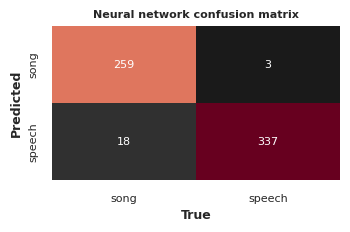

In [110]:
plot_cfm(y_test, y_pred_test, title="Neural network confusion matrix", cmap=CMAP_CFM)

In [111]:
net.model_.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               23200     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 43,501
Trainable params: 43,501
Non-trainable params: 0
_________________________________________________________________


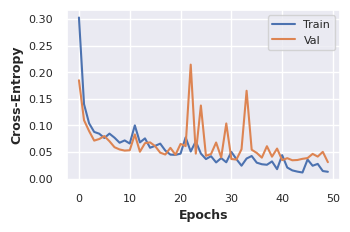

In [112]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

200/200 [==============================] - 1s 3ms/step


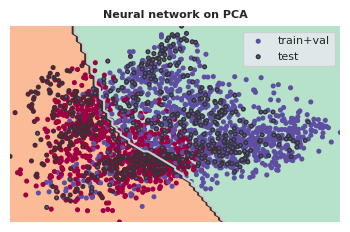

In [122]:
boundaries_on_embedding(reducer, net, embedding=embedding, 
                        n_pts=N_PTS,
                       cmap=CMAP,
                       title="Neural network on PCA")

# Ensemble methods

## Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [46]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 16:41:04,591] A new study created in memory with name: no-name-d69fab44-34cc-4f37-a55e-51ab82322ea8
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[W 2023-07-08 16:41:04,604] Trial 1 failed with parameters: {'n_estimators': 1330, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 3, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-08 16:41:50,610] Trial 7 finished with value: 0.9724517906336089 and parameters: {'n_estimators': 820, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 4 with value: 0.977961432506887.
[I 2023-07-08 16:41:53,406] Trial 5 finished with value: 0.9834710743801653 and parameters: {'n_estimators': 980, 'max_depth': 60, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 5 with value: 0.9834710743801653.
/home/djanloo/.local/s

[W 2023-07-08 16:43:04,328] Trial 23 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-08 16:43:36,312] Trial 18 finished with value: 0.9834710743801653 and parameters: {'n_estimators': 1550, 'max_depth': 70, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 5 with value: 0.9834710743801653.
[W 2023-07-08 16:43:36,379] Trial 25 failed with parameters: {'n_estimators': 1940, 'max_depth': 60, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidPa

[W 2023-07-08 16:43:37,587] Trial 30 failed with value None.
[W 2023-07-08 16:43:37,656] Trial 31 failed with parameters: {'n_estimators': 2000, 'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenv

[W 2023-07-08 16:43:50,162] Trial 36 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-08 16:43:58,842] Trial 35 finished with value: 0.9807162534435262 and parameters: {'n_estimators': 580, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 5 with value: 0.9834710743801653.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

In [47]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 590, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       262
           1       0.99      0.95      0.97       355

    accuracy                           0.97       617
   macro avg       0.97      0.97      0.97       617
weighted avg       0.97      0.97      0.97       617

Accuracy 0.9692058346839546
F1-score [0.96474954 0.97266187]


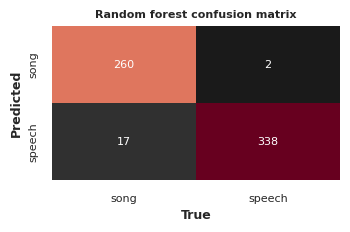

In [48]:
plot_cfm(y_test, y_pred_test, title="Random forest confusion matrix", cmap=CMAP_CFM)

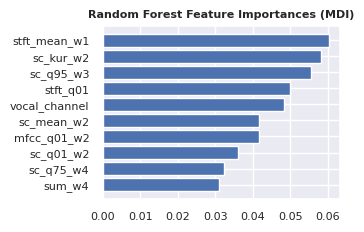

In [49]:
nbr_features = X_train.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

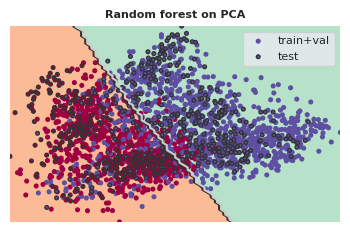

In [123]:
boundaries_on_embedding(reducer, rf, embedding=embedding,
                       cmap=CMAP,
                       n_pts=N_PTS,
                        title="Random forest on PCA")

In [51]:
from sklearn.inspection import permutation_importance

In [52]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

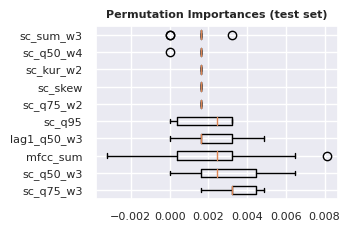

In [53]:
sorted_idx = result.importances_mean.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [54]:
from sklearn.tree import plot_tree

In [55]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=7, random_state=953849902)

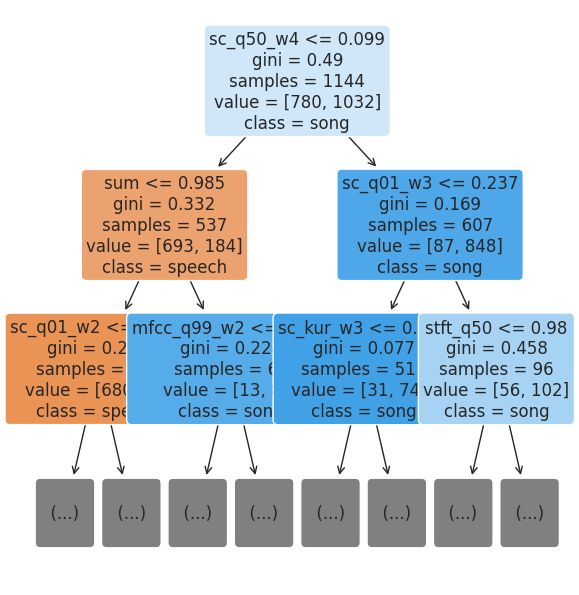

In [56]:
plt.figure(figsize=(6,6))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

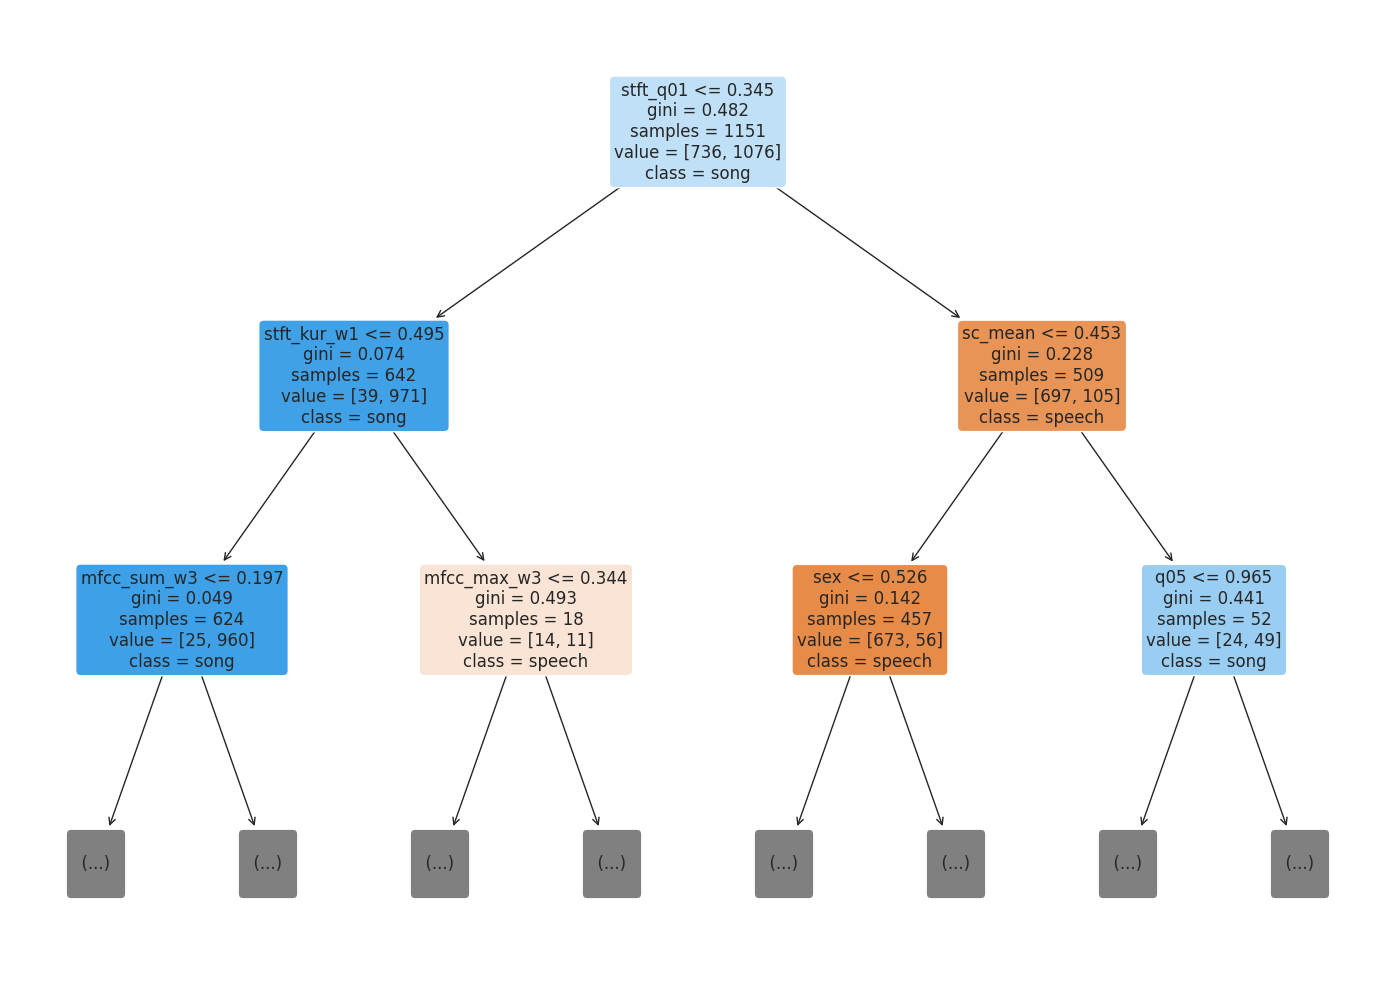

In [57]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [59]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 16:49:21,785] A new study created in memory with name: no-name-10468d8f-8b42-4053-be20-3c80e354227e
[W 2023-07-08 16:49:21,799] Trial 0 failed with parameters: {'n_estimators': 8, 'max_depth': 70, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 1, 'learning_rate': 0.126101589132053, 'criterion': 'mae', 'subsample': 0.9494740022433226, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb

[W 2023-07-08 16:49:21,874] Trial 5 failed with value None.
[W 2023-07-08 16:49:21,895] Trial 7 failed with parameters: {'n_estimators': 19, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 2, 'learning_rate': 0.11439530022090083, 'criterion': 'mae', 'subsample': 0.5072745778150752, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 16:49:22,574] Trial 13 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[I 2023-07-08 16:49:23,147] Trial 11 finished with value: 0.9972451790633609 and parameters: {'n_estimators': 9, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'learning_rate': 0.10537140728024594, 'criterion': 'friedman_mse', 'subsample': 0.8821367688449695, 'loss': 'deviance'}. Best is trial 12 with value: 0.9972451790633609.
[W 2023-07-08 16:49:23,162] Trial 15 failed with parameters: {'n_estimators': 2, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 1, 'learning_rate': 0.06123778471187201, 'criterion': 'mae', 'subsample': 0.8079820846764637, 'loss': 'dev

[W 2023-07-08 16:49:24,120] Trial 21 failed with value None.
[I 2023-07-08 16:49:24,227] Trial 17 finished with value: 0.9972451790633609 and parameters: {'n_estimators': 4, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 7, 'learning_rate': 0.07473937850686221, 'criterion': 'friedman_mse', 'subsample': 0.7732573321354124, 'loss': 'deviance'}. Best is trial 12 with value: 0.9972451790633609.
[W 2023-07-08 16:49:24,239] Trial 23 failed with parameters: {'n_estimators': 18, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 10, 'learning_rate': 0.06705705333461522, 'criterion': 'mae', 'subsample': 0.8555203106390079, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib

[W 2023-07-08 16:49:25,628] Trial 30 failed with value None.
[W 2023-07-08 16:49:25,698] Trial 31 failed with parameters: {'n_estimators': 1, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.29319811696109666, 'criterion': 'mae', 'subsample': 0.6479387943565184, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 16:49:26,097] Trial 36 failed with value None.
[W 2023-07-08 16:49:26,176] Trial 37 failed with parameters: {'n_estimators': 1, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.28688675202021446, 'criterion': 'mae', 'subsample': 0.6455601893338234, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 16:49:26,591] Trial 42 failed with value None.
[W 2023-07-08 16:49:26,667] Trial 43 failed with parameters: {'n_estimators': 14, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 1, 'learning_rate': 0.2776656592269339, 'criterion': 'mae', 'subsample': 0.650304258872888, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
 

[W 2023-07-08 16:49:27,056] Trial 48 failed with value None.
[W 2023-07-08 16:49:27,144] Trial 49 failed with parameters: {'n_estimators': 1, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.29623722977647726, 'criterion': 'mae', 'subsample': 0.6476528893297812, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 16:49:27,535] Trial 54 failed with value None.
[W 2023-07-08 16:49:27,610] Trial 55 failed with parameters: {'n_estimators': 14, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.27790516347006267, 'criterion': 'mae', 'subsample': 0.6566122444199785, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-08 16:49:28,027] Trial 60 failed with value None.
[W 2023-07-08 16:49:28,105] Trial 61 failed with parameters: {'n_estimators': 1, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.2939393068712155, 'criterion': 'mae', 'subsample': 0.6337822297245846, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
 

[W 2023-07-08 16:49:28,519] Trial 66 failed with value None.
[W 2023-07-08 16:49:28,598] Trial 67 failed with parameters: {'n_estimators': 14, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 1, 'learning_rate': 0.2869037714826026, 'criterion': 'mae', 'subsample': 0.6409857563160593, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 16:49:29,032] Trial 72 failed with value None.
[W 2023-07-08 16:49:29,106] Trial 73 failed with parameters: {'n_estimators': 1, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.29919369236334314, 'criterion': 'mae', 'subsample': 0.6305415278246327, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 16:49:29,509] Trial 78 failed with value None.
[W 2023-07-08 16:49:29,584] Trial 79 failed with parameters: {'n_estimators': 1, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.29476648656649274, 'criterion': 'mae', 'subsample': 0.6910936321130159, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 16:49:29,992] Trial 84 failed with value None.
[W 2023-07-08 16:49:30,074] Trial 85 failed with parameters: {'n_estimators': 14, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.2714821564184778, 'criterion': 'mae', 'subsample': 0.6412591038407756, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 16:49:30,490] Trial 90 failed with value None.
[W 2023-07-08 16:49:30,567] Trial 91 failed with parameters: {'n_estimators': 1, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.2816907684685627, 'criterion': 'mae', 'subsample': 0.6491281995871974, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
 

[W 2023-07-08 16:49:30,980] Trial 96 failed with value None.
[W 2023-07-08 16:49:31,055] Trial 97 failed with parameters: {'n_estimators': 14, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.26990776829038726, 'criterion': 'mae', 'subsample': 0.6469077986068557, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_127316/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

In [60]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


{'n_estimators': 7, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 7, 'learning_rate': 0.19151045788730958, 'criterion': 'friedman_mse', 'subsample': 0.7510331734636644, 'loss': 'deviance'}
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       262
           1       0.98      0.95      0.97       355

    accuracy                           0.96       617
   macro avg       0.96      0.96      0.96       617
weighted avg       0.96      0.96      0.96       617

Accuracy 0.9627228525121556
F1-score [0.95700935 0.96709585]


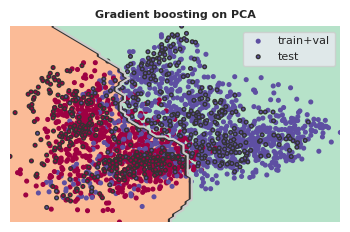

In [124]:
boundaries_on_embedding(reducer, gb, embedding=embedding,
                       cmap=CMAP,
                       n_pts=N_PTS,
                       title="Gradient boosting on PCA")

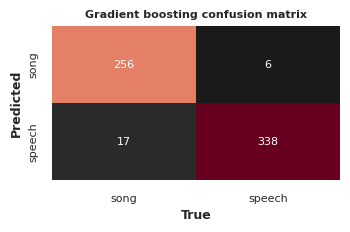

In [62]:
plot_cfm(y_test, y_pred_test, title="Gradient boosting confusion matrix", cmap=CMAP_CFM)